Min train loss and val loss:  2.229784922166304 2.565238748277937
At:  410 104
[2.69987004 2.61669138 2.63283747 2.5987353  2.58535743 2.581608
 2.56202686 2.55936873 2.54779063 2.53055903 2.49797714 2.50697753
 2.45708233 2.45496889 2.46688025 2.45546001 2.45378479 2.41874997
 2.4179733  2.43156359 2.41059967 2.41385063 2.38414091 2.40192733
 2.37516106 2.39727946 2.39829524 2.37090992 2.37075526 2.35937896
 2.33960486 2.37079555 2.33583815 2.35546325 2.34908865 2.36429739
 2.34996915 2.34067304 2.33344616 2.3442771  2.35226065 2.33482722
 2.32341825 2.30927861 2.32215783 2.32240424 2.32655655 2.31767512
 2.32777251 2.31031537]
[2.83833275 2.84319951 2.76494573 2.77049099 2.74826882 2.78073939
 2.78812155 2.78437468 2.80955411 2.81775335 2.7571756  2.7737011
 2.91325621 2.87002963 2.9058701  2.8788269  3.06025824 3.19515961
 3.20402252 3.10548573 3.50862713 3.2080576  3.52815243 3.81908936
 4.05938609 3.52985379 3.88251659 4.04158184 4.19367472 4.16255387
 4.40013643 4.13912911 4.8373

Text(0.5, 1.0, 'Validation Accuracy')

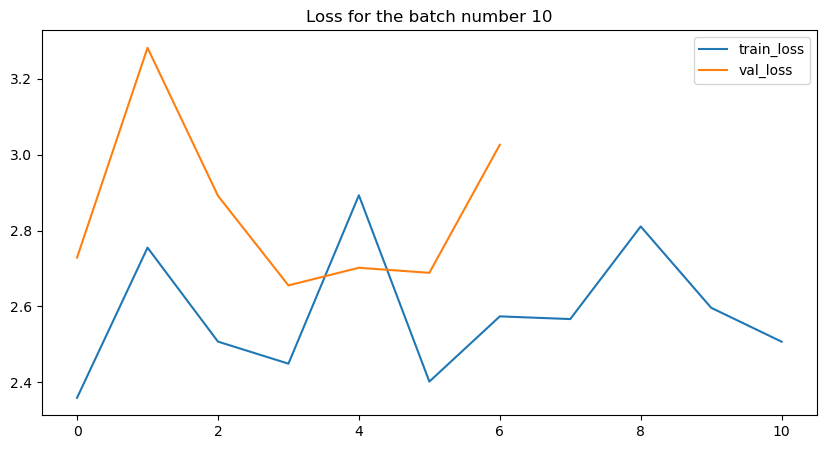

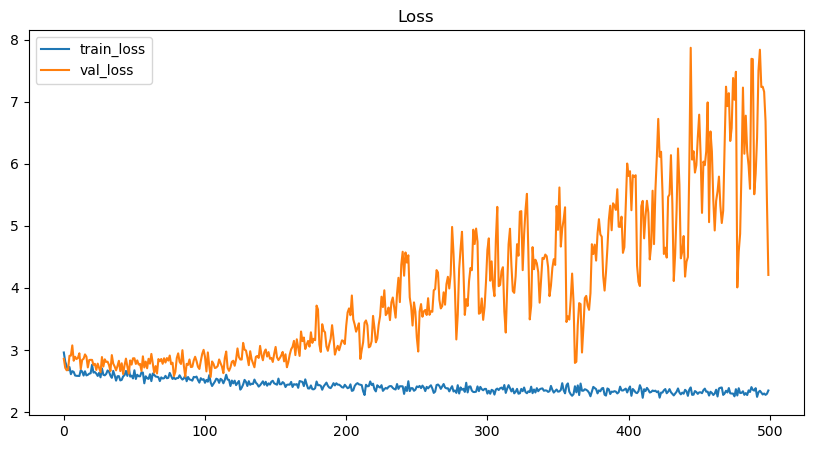

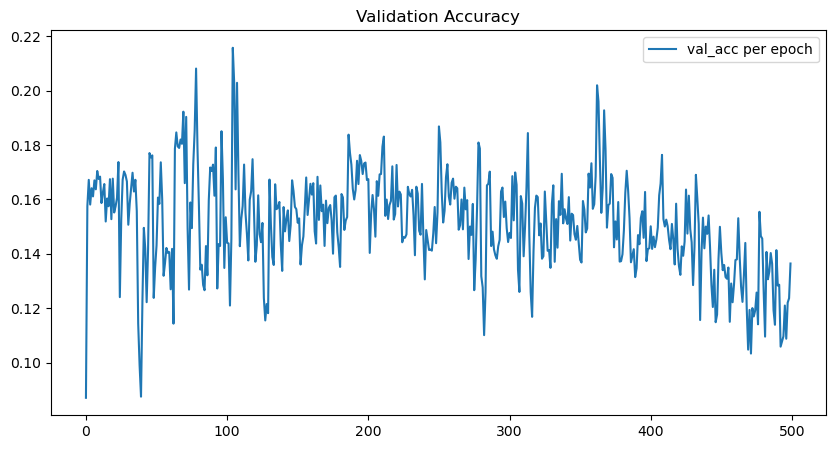

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np
# Import the metrics file
metrics = torch.load('Model/metrics.pth')



# Training and Validation loss for the first batch
batch = 10 
plt.figure(figsize=(10, 5))
plt.plot(metrics['trainloss_per_batch'][batch-1], label='train_loss')
plt.plot(metrics['valloss_per_batch'][batch-1], label='val_loss')
plt.legend()
plt.title(f"Loss for the batch number {batch}")


trainloss = np.concatenate(metrics['trainloss_per_batch'])
valloss = np.concatenate(metrics['valloss_per_batch'])

print('Min train loss and val loss: ', np.min(metrics['trainloss_per_epoch']), np.min(metrics['valloss_per_epoch']))
print('At: ', np.argmin(metrics['trainloss_per_epoch']), np.argmin(metrics['valloss_per_epoch']))

# Averaging the train loss per epoch over an interaval of 10 epochs (50 values instead of 500)
trainloss_avg = np.mean(np.array(metrics['trainloss_per_epoch']).reshape(-1, 10), axis=1)
print(trainloss_avg)

# Averaging the val loss per epoch over an interaval of 10 epochs (50 values instead of 500)
valloss_avg = np.mean(np.array(metrics['valloss_per_epoch']).reshape(-1, 10), axis=1)
print(valloss_avg)



# plot the metrics
plt.figure(figsize=(10, 5))
plt.plot(metrics['trainloss_per_epoch'], label='train_loss')
plt.plot(metrics['valloss_per_epoch'], label='val_loss')
plt.legend()
plt.title('Loss')
plt.figure(figsize=(10, 5))
plt.plot(metrics['valacc_per_epoch'], label='val_acc per epoch')
plt.legend()
plt.title('Validation Accuracy')

